https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb

In [1]:
import pandas as pd
import sagemaker
import boto3
import json
import matplotlib.pyplot as plt
import s3fs
from datetime import timedelta
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

# Configure

In [2]:
sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()
s3_prefix = 'deepar-ironia-ajg' 
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
s3 = boto3.resource('s3')

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


# Load timeseries

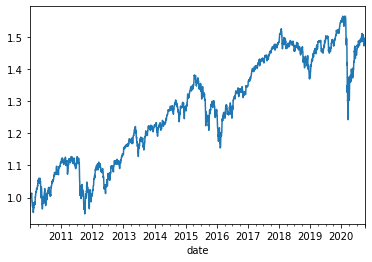

In [3]:
data = pd.read_csv('s3://sagemakerbmeironia/sagemaker_input_data/data.csv', sep=';')
data['date'] = pd.to_datetime(data['date_ws'])
data.set_index('date', inplace=True)
data = data.resample('1D').mean()

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='ffill', inplace=True)
    check_equal_df = data.equals(data_pre)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='bfill', inplace=True)
    check_equal_df = data.equals(data_pre)
    
returns = np.log(data).diff().dropna()

market = returns.mean(axis=1)
market.iloc[0] = 1
cummarket = market.cumsum()

cummarket.plot()

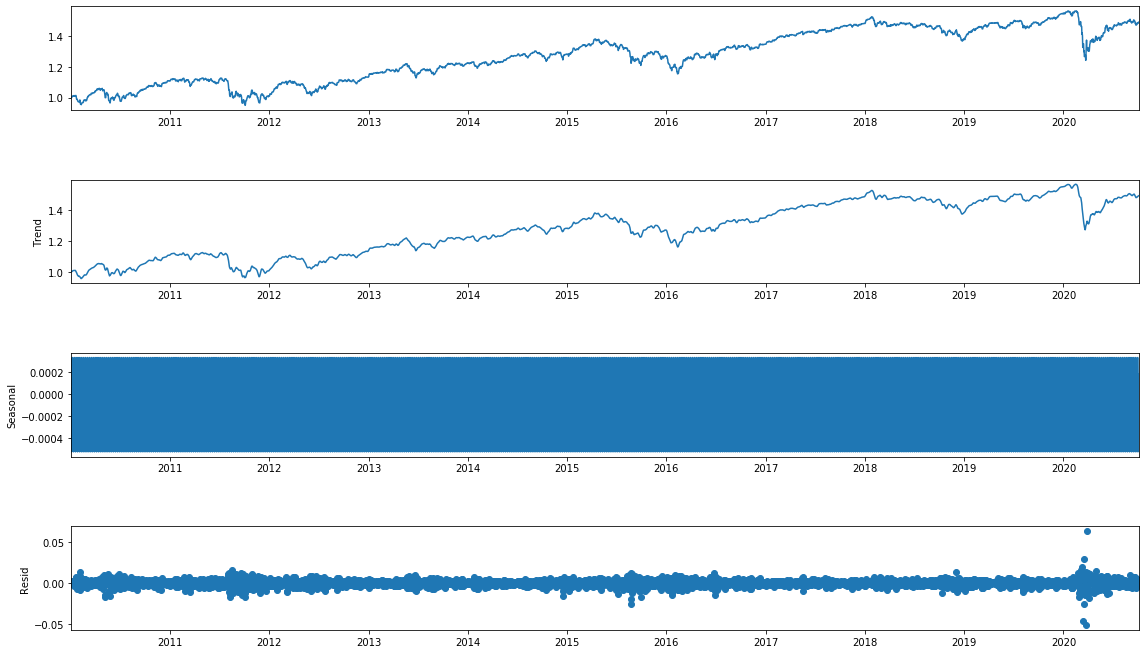

In [4]:
result = seasonal_decompose(cummarket, model='additive')
fig = result.plot()
fig.set_size_inches(18.5, 10, forward=True)
plt.show()

In [5]:
timeseries = [cummarket]

# Splits

In [6]:
freq = '1D'

# Días a predecir 
prediction_length = 20

# Longitud necesaria para predecir
context_length = 20

In [7]:
prop_split = 0.7
total_len = len(data.index.tolist())
index_split = int(prop_split*total_len)

In [8]:
start_dataset = pd.Timestamp(data.index.tolist()[0], freq=freq)
end_training = pd.Timestamp(data.index.tolist()[index_split], freq=freq)

In [9]:
training_data = [{"start": str(start_dataset),
                  "target": ts[start_dataset:end_training - timedelta(days=1)].tolist()} 
                 for ts in timeseries]

In [10]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(days=k * prediction_length)].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]


In [11]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [12]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.3 ms


In [13]:
def copy_to_s3(local_file, s3_path, override=True):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [14]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-561323288832/deepar-ironia-ajg/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-561323288832/deepar-ironia-ajg/data/test/test.json
CPU times: user 44.9 ms, sys: 29 µs, total: 44.9 ms
Wall time: 210 ms


In [15]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2010-01-01 00:00:00", "target": [1.0, 1.0, 1.0002013121115232, 1.0054293524950635, 1.0087...


# Entrenamiento

In [16]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    base_job_name='bme-ajg-ironia',
    output_path=s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [17]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "10",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [18]:
estimator.set_hyperparameters(**hyperparameters)

In [19]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-31 11:44:11 Starting - Starting the training job...
2020-10-31 11:44:13 Starting - Launching requested ML instances......
2020-10-31 11:45:35 Starting - Preparing the instances for training......
2020-10-31 11:46:24 Downloading - Downloading input data...
2020-10-31 11:47:06 Training - Training image download completed. Training in progress.Arguments: train
[10/31/2020 11:47:07 INFO 140079058356032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

# Desplegar

In [20]:

class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [21]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.4xlarge',
    predictor_cls=DeepARPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

# Obtener predicción

In [22]:
x_test = timeseries[0].iloc[:-prediction_length]
y_test = timeseries[0].iloc[-prediction_length:]

In [23]:
pred = predictor.predict(ts=x_test, quantiles=[0.10, 0.5, 0.90])
pred['true'] = y_test 

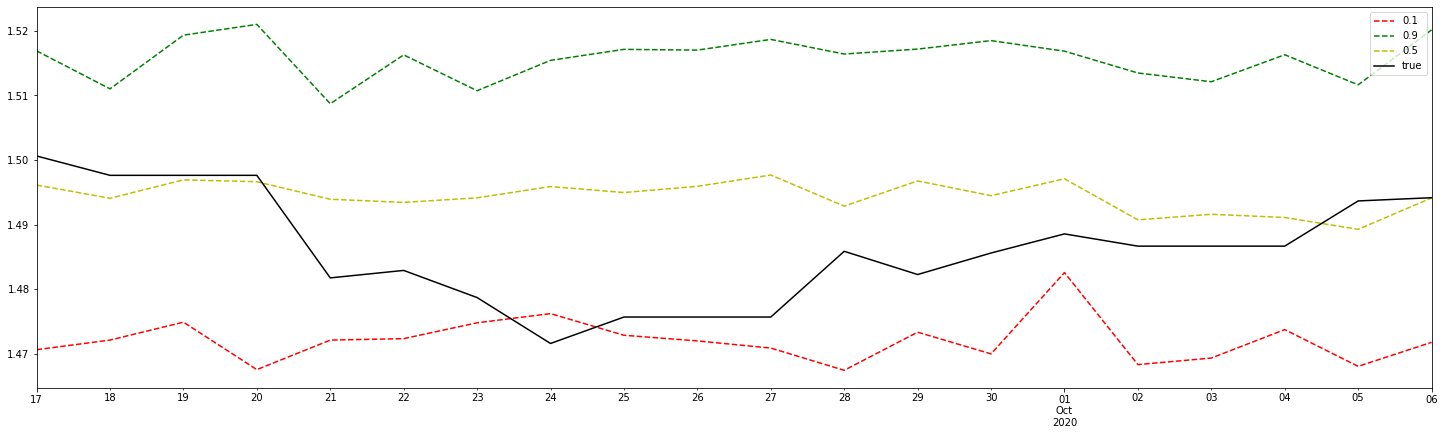

In [24]:
styles=['--r', '--g', '--y', '-k']
pred.plot(figsize=(25,7), style=styles)

In [25]:
r2_score(pred['true'].values, pred['0.5'].values)

-1.0962436895402354

# Borrar endpoint

In [26]:
predictor.delete_endpoint()